In [3]:
from dotenv import load_dotenv

load_dotenv
import os

In [4]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    model="gpt-4.1-mini",
    temperature=0.2,
    api_key=os.getenv("OPENAI_API_KEY"),
)

In [5]:
result = llm.invoke("What is an agent?")

In [6]:
print(result)

content='An **agent** is an entity that can perceive its environment through sensors and act upon that environment through actuators to achieve specific goals. Agents are commonly discussed in fields like artificial intelligence, robotics, and software engineering.\n\n### In Artificial Intelligence:\n- An **intelligent agent** is a system that **autonomously** makes decisions and takes actions based on its perceptions and programmed objectives.\n- It can be as simple as a thermostat (which senses temperature and turns heating on/off) or as complex as a self-driving car (which processes sensor data to navigate roads safely).\n\n### Key Characteristics of an Agent:\n1. **Autonomy:** Operates without direct human intervention.\n2. **Perception:** Senses the environment.\n3. **Action:** Acts upon the environment.\n4. **Goal-oriented:** Works towards achieving specific objectives.\n5. **Adaptability:** Can learn or adapt to changes in the environment (in more advanced agents).\n\n### Exampl

In [7]:
from langchain.tools import tool


@tool
def write_email(
    to: str,
    subject: str,
    content: str,
) -> str:
    """write and send an email"""
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

In [8]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [9]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [10]:
model_with_tool = llm.bind_tools(
    [write_email],
    tool_choice="any",
    parallel_tool_calls=False,
)
output = model_with_tool.invoke(
    "Draft a response to my boss (boss@company.ai) about tomorrow's meeting"
)

In [11]:
type(output)

langchain_core.messages.ai.AIMessage

In [12]:
output

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 67, 'total_tokens': 169, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_d0c93c37b1', 'id': 'chatcmpl-Cp57LH8P2ol5Obs3DBtGlCnMIaXE0', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b3f1d-2938-7123-b6b1-7e549b24f436-0', tool_calls=[{'name': 'write_email', 'args': {'to': 'boss@company.ai', 'subject': "Re: Tomorrow's Meeting", 'content': "Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I have reviewed the agenda and am preparing the necessary materials. Please let me know if there are any specific topics you would like me to focus on 

In [13]:
args = output.tool_calls[0]["args"]
args

{'to': 'boss@company.ai',
 'subject': "Re: Tomorrow's Meeting",
 'content': "Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I have reviewed the agenda and am preparing the necessary materials. Please let me know if there are any specific topics you would like me to focus on or any additional information I should bring.\n\nLooking forward to the meeting.\n\nBest regards,\n[Your Name]"}

In [14]:
result = write_email.invoke(args)

In [15]:
result

"Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I have reviewed the agenda and am preparing the necessary materials. Please let me know if there are any specific topics you would like me to focus on or any additional information I should bring.\n\nLooking forward to the meeting.\n\nBest regards,\n[Your Name]"

In [16]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class state_schema(TypedDict):
    request: str
    email: str


workflow = StateGraph(state_schema)

In [17]:
def write_email_node(state: state_schema) -> state_schema:
    output = model_with_tool.invoke(state["request"])
    args = output.tool_calls[0]["args"]
    email = write_email.invoke(args)
    return {"email": email}

In [18]:
workflow = StateGraph(state_schema)
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()

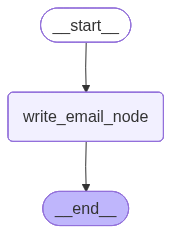

In [19]:
app

In [20]:
app.invoke(
    {
        "request": "Draft a response to my boss (boss@company.ai) about tomorrow's meeting"
    }
)

{'request': "Draft a response to my boss (boss@company.ai) about tomorrow's meeting",
 'email': "Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. Please let me know if there are any specific topics or materials I should prepare in advance.\n\nLooking forward to it.\n\nBest regards,\n[Your Name]"}

In [22]:
from typing import Literal
from langgraph.graph import MessagesState


def call_llm(state: MessagesState) -> MessagesState:
    """Run llm"""
    output = model_with_tool.invoke(state["messages"])
    return {"messages": [output]}


def run_tool(state: MessagesState):
    """perform the tool call"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append(
            {"role": "tool", "content": observation, "tool_call_id": tool_call["id"]}
        )
    return {"messages": result}


def should_continue(state: MessagesState) -> Literal["run_tool", "__end__"]:
    """Route to tool handler, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "run_tool"
    return END


workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges(
    "call_llm", should_continue, {"run_tool": "run_tool", END: END}
)
workflow.add_edge("run_tool", END)
app=workflow.compile()

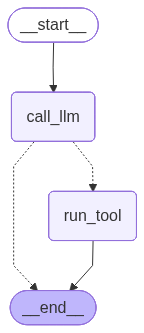

In [23]:
app

In [24]:
result = app.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!",
            }
        ]
    }
)
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_AAaVkr0lR2oADVNEms2wA1F3)
 Call ID: call_AAaVkr0lR2oADVNEms2wA1F3
  Args:
    to: boss@company.ai
    subject: Confirmation: Attendance at Interrupt!
    content: Dear Boss,

I hope this message finds you well. I am writing to confirm that I would like to attend Interrupt! as discussed.

Please let me know if there are any further details or preparations needed on my part.

Thank you for the opportunity.

Best regards,
[Your Name]
================================= Tool Message =================================

Email sent to boss@company.ai with subject 'Confirmation: Attendance at Interrupt!' and content: Dear Boss,

I hope this message finds you well. I am writing to confirm that I would like to attend I

In [34]:
from langchain.agents import create_agent

from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided.",
)

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!",
            }
        ]
    }
)

for m in result["messages"]:
    m.pretty_print()

/var/folders/t8/fn43kkgj3290mbyjgx7rv6v40000gn/T/ipykernel_6940/1139792465.py:5: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(


================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_VhESJXKFX9OByPpCN41nBO0c)
 Call ID: call_VhESJXKFX9OByPpCN41nBO0c
  Args:
    to: boss@company.ai
    subject: Confirmation of Attendance at Interrupt
    content: Dear Boss,

I am writing to confirm that I would like to attend Interrupt. Please let me know if there are any further details or preparations needed from my side.

Thank you.

Best regards,
[Your Name]
================================= Tool Message =================================
Name: write_email

Email sent to boss@company.ai with subject 'Confirmation of Attendance at Interrupt' and content: Dear Boss,

I am writing to confirm that I would like to attend Interrupt. Please let me know if there are any further details or preparations needed 

In [ ]:
from langgraph.checkpoint.memory import InMemorySaver

agent= create_react_agent(
    model=llm,
    tool=[write_email],
    
)